# Tradução Automática (D2L 9.5) — ENG→POR


- aquisição de dados com múltiplos fallbacks (Tatoeba/OPUS/Upload),
- limpeza e tokenização,
- vocabulários separados (src/tgt),
- Seq2Seq com GRU (teacher forcing),
- avaliação BLEU,
- exercícios 9.5.7 (varrer `num_examples` e discutir tokenização em idiomas sem separadores).


In [1]:
import sys, platform, random, numpy as np, torch
SEED = 13
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("CUDA:", torch.cuda.is_available(), "| device:", "cuda" if torch.cuda.is_available() else "cpu")
print("OS:", platform.platform())


Python: 3.12.11
PyTorch: 2.8.0+cu126
CUDA: True | device: cuda
OS: Linux-6.1.123+-x86_64-with-glibc2.35


## 1) Configuração


In [2]:
# Idiomas (ISO-3 para Tatoeba; mapeamos para ISO-2 quando necessário)
SRC_LANG = "eng"   # origem
TGT_LANG = "por"   # destino
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

# Mapas ISO-3 -> ISO-2 (para datasets como opus100/opus_books)
ISO3_TO_ISO2 = {
    "eng":"en","fra":"fr","por":"pt","spa":"es","deu":"de","ita":"it","nld":"nl","ron":"ro",
    "jpn":"ja","zho":"zh","cmn":"zh","ell":"el","rus":"ru","pol":"pl","ara":"ar"
}
SRC2 = ISO3_TO_ISO2.get(SRC_LANG, SRC_LANG[:2])
TGT2 = ISO3_TO_ISO2.get(TGT_LANG, TGT_LANG[:2])

# Amostragem/partições
NUM_EXAMPLES = 50000
VAL_FRAC     = 0.05
TEST_FRAC    = 0.05
MAX_TOKENS   = 50

# Varredura para 9.5.7
EXAMPLE_GRID = [500, 1000, 2000, 6000, 10000, 20000]

# Vocabulário
MIN_FREQ     = 2
SPECIALS     = ["<pad>","<bos>","<eos>","<unk>"]

# Treino
BATCH_SIZE   = 128
EMB_DIM      = 256
HID_DIM      = 512
LAYERS       = 1
DROPOUT      = 0.1
LR           = 2e-3
EPOCHS       = 5
TEACHER_P    = 0.5

print(f"Config: {SRC_LANG}->{TGT_LANG} (iso2: {SRC2}->{TGT2}) | {DEVICE}")


Config: eng->por (iso2: en->pt) | cuda


## 2) Aquisição de dados (camadas)
1. `Helsinki-NLP/tatoeba_mt` — configuração `eng-por` (ou `por-eng`, com swap).
2. `opus100` — configuração `en-pt`.
3. `opus_books` — configuração `en-pt` (se existir).
4. Upload manual (`EN<TAB>PT`).
Saída: `raw_src`, `raw_tgt` (listas de strings).


In [3]:
# Se necessário no Colab, descomente:
# !pip -q install datasets==2.21.0

import io
from typing import List, Tuple

raw_src: List[str] = []
raw_tgt: List[str] = []
DATA_ORIGIN = None

def _limit(xs, ys, n):
    if n and len(xs) > n: return xs[:n], ys[:n]
    return xs, ys

def try_tatoeba_generic(src3, tgt3, limit):
    try:
        from datasets import load_dataset
        cfg = f"{src3}-{tgt3}"
        ds = load_dataset("Helsinki-NLP/tatoeba_mt", cfg, split="test")
        xs, ys = [], []
        for ex in ds:
            if "source_sentence" in ex and "target_sentence" in ex:
                xs.append(ex["source_sentence"]); ys.append(ex["target_sentence"])
            elif "translation" in ex and isinstance(ex["translation"], dict):
                tr = ex["translation"]
                if src3.startswith("eng"): xs.append(tr.get("en",""))
                else: xs.append(tr.get(src3,""))
                if tgt3.startswith("por"): ys.append(tr.get("pt",""))
                else: ys.append(tr.get(tgt3,""))
            if len(xs) >= limit: break
        if not xs:
            # tenta inverso e inverte colunas
            cfg = f"{tgt3}-{src3}"
            ds = load_dataset("Helsinki-NLP/tatoeba_mt", cfg, split="test")
            xs, ys = [], []
            for ex in ds:
                if "source_sentence" in ex and "target_sentence" in ex:
                    ys.append(ex["source_sentence"]); xs.append(ex["target_sentence"])  # swap
                elif "translation" in ex:
                    tr=ex["translation"]; ys.append(tr.get("pt", tr.get(tgt3,""))); xs.append(tr.get("en", tr.get(src3,"")))
                if len(xs) >= limit: break
        return _limit(xs, ys, limit)
    except Exception as e:
        print("[tatoeba_mt] indisponível:", e)
        return [], []

def try_opus100(src2, tgt2, limit):
    try:
        from datasets import load_dataset
        cfg = f"{src2}-{tgt2}"
        ds = load_dataset("opus100", cfg, split="train")
        xs, ys = [], []
        for ex in ds:
            tr = ex.get("translation", {})
            if src2 in tr and tgt2 in tr:
                xs.append(tr[src2]); ys.append(tr[tgt2])
            if len(xs) >= limit: break
        if xs: return _limit(xs, ys, limit)
        # tenta inverso e inverte
        cfg = f"{tgt2}-{src2}"
        ds = load_dataset("opus100", cfg, split="train")
        xs, ys = [], []
        for ex in ds:
            tr = ex.get("translation", {})
            if src2 in tr and tgt2 in tr:
                ys.append(tr[src2]); xs.append(tr[tgt2])  # swap
            if len(xs) >= limit: break
        return _limit(xs, ys, limit)
    except Exception as e:
        print("[opus100] indisponível:", e)
        return [], []

def try_opus_books(src2, tgt2, limit):
    try:
        from datasets import load_dataset
        cfg = f"{src2}-{tgt2}"
        ds = load_dataset("opus_books", cfg, split="train")
        xs, ys = [], []
        for ex in ds:
            tr = ex.get("translation", {})
            if src2 in tr and tgt2 in tr:
                xs.append(tr[src2]); ys.append(tr[tgt2])
            if len(xs) >= limit: break
        if xs: return _limit(xs, ys, limit)
        # inverso com swap
        cfg = f"{tgt2}-{src2}"
        ds = load_dataset("opus_books", cfg, split="train")
        xs, ys = [], []
        for ex in ds:
            tr = ex.get("translation", {})
            if src2 in tr and tgt2 in tr:
                ys.append(tr[src2]); xs.append(tr[tgt2])  # swap
            if len(xs) >= limit: break
        return _limit(xs, ys, limit)
    except Exception as e:
        print("[opus_books] indisponível:", e)
        return [], []

def try_manual():
    print("Faça upload de um arquivo TSV/TXT com linhas: ENGLISH<TAB>PORTUGUESE")
    try:
        from google.colab import files
        up = files.upload()
        xs, ys = [], []
        for name, content in up.items():
            data = io.StringIO(content.decode("utf-8", errors="ignore"))
            for ln in data:
                parts = ln.rstrip("\n").split("\t")
                if len(parts) < 2: continue
                xs.append(parts[0]); ys.append(parts[1])
        return xs, ys
    except Exception as e:
        print("Upload manual indisponível:", e)
        return [], []

limit = max(NUM_EXAMPLES, 60000)

xs, ys = try_tatoeba_generic(SRC_LANG, TGT_LANG, limit)
if xs:
    raw_src, raw_tgt = xs, ys; DATA_ORIGIN = "tatoeba_mt (HF)"
else:
    xs, ys = try_opus100(SRC2, TGT2, limit)
    if xs:
        raw_src, raw_tgt = xs, ys; DATA_ORIGIN = "opus100 (HF)"
    else:
        xs, ys = try_opus_books(SRC2, TGT2, limit)
        if xs:
            raw_src, raw_tgt = xs, ys; DATA_ORIGIN = "opus_books (HF)"
        else:
            xs, ys = try_manual()
            if xs:
                raw_src, raw_tgt = xs, ys; DATA_ORIGIN = "manual upload"

if not raw_src:
    raise RuntimeError("Nenhuma fonte disponível. Verifique rede ou use upload manual.")

if NUM_EXAMPLES and len(raw_src) > NUM_EXAMPLES:
    raw_src, raw_tgt = raw_src[:NUM_EXAMPLES], raw_tgt[:NUM_EXAMPLES]

print(f"Fonte: {DATA_ORIGIN} | pares brutos: {len(raw_src)}")
print("Amostra:", raw_src[0][:80], "→", raw_tgt[0][:80])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

tatoeba_mt.py: 0.00B [00:00, ?B/s]

[tatoeba_mt] indisponível: Dataset scripts are no longer supported, but found tatoeba_mt.py


README.md: 0.00B [00:00, ?B/s]

en-pt/test-00000-of-00001.parquet:   0%|          | 0.00/220k [00:00<?, ?B/s]

en-pt/train-00000-of-00001.parquet:   0%|          | 0.00/87.2M [00:00<?, ?B/s]

en-pt/validation-00000-of-00001.parquet:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Fonte: opus100 (HF) | pares brutos: 50000
Amostra: One, two, three. One, two, three. One, two, three. → 1, 2, 3...


## 3) Limpeza, tokenização e análise


Pares após filtros: 48981


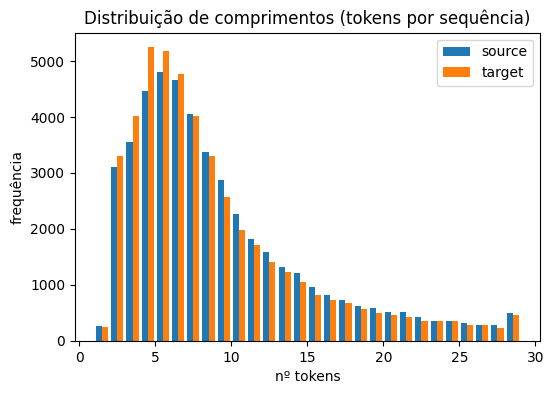

In [4]:
import re, matplotlib.pyplot as plt

def basic_clean(s: str) -> str:
    s = s.replace("\u202f"," ").replace("\xa0"," ").strip().lower()
    s = re.sub(r"([?.!,;:])", r" \1 ", s)
    s = re.sub(r"[^a-zA-ZÀ-ÿ0-9?.!,;:'’`\- \t]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def split_tokens(s: str): return basic_clean(s).split()

src_tok, tgt_tok = [], []
for a,b in zip(raw_src, raw_tgt):
    ta, tb = split_tokens(a), split_tokens(b)
    if len(ta) <= MAX_TOKENS and len(tb) <= MAX_TOKENS:
        src_tok.append(ta); tgt_tok.append(tb)

print(f"Pares após filtros: {len(src_tok)}")

len_src = [len(x) for x in src_tok]
len_tgt = [len(y) for y in tgt_tok]
plt.figure(figsize=(6,4))
plt.hist([len_src, len_tgt], bins=range(1, 30), label=["source","target"])
plt.title("Distribuição de comprimentos (tokens por sequência)")
plt.xlabel("nº tokens"); plt.ylabel("frequência"); plt.legend(); plt.show()


## 4) Vocabulários (src/tgt)


In [5]:
from collections import Counter, defaultdict
from dataclasses import dataclass

@dataclass
class Lexicon:
    itos: list; stoi: dict; pad: int; bos: int; eos: int; unk: int

def make_vocab(token_lists, min_freq=1, specials=None) -> Lexicon:
    specials = specials or ["<pad>","<bos>","<eos>","<unk>"]
    freq = Counter()
    for seq in token_lists: freq.update(seq)
    itos = list(specials); seen = set(specials)
    for tok, c in freq.most_common():
        if c >= min_freq and tok not in seen:
            itos.append(tok); seen.add(tok)
    stoi = defaultdict(lambda: itos.index("<unk>"))
    for i,t in enumerate(itos): stoi[t] = i
    return Lexicon(itos, stoi, stoi["<pad>"], stoi["<bos>"], stoi["<eos>"], stoi["<unk>"])

src_vocab = make_vocab(src_tok, MIN_FREQ)
tgt_vocab = make_vocab(tgt_tok, MIN_FREQ)
print("Tamanho vocab SRC:", len(src_vocab.itos))
print("Tamanho vocab TGT:", len(tgt_vocab.itos))


Tamanho vocab SRC: 13539
Tamanho vocab TGT: 16816


## 5) Dataset, padding e DataLoaders


In [6]:
from torch.utils.data import Dataset, DataLoader
import torch

def to_ids(tokens, lx: Lexicon):
    return [lx.stoi["<bos>"]] + [lx.stoi.get(t, lx.unk) for t in tokens] + [lx.stoi["<eos>"]]

pairs = [(to_ids(s, src_vocab), to_ids(t, tgt_vocab)) for s,t in zip(src_tok, tgt_tok)]

N = len(pairs)
n_val  = int(VAL_FRAC  * N)
n_test = int(TEST_FRAC * N)
n_trn  = N - n_val - n_test
train_set = pairs[:n_trn]; val_set = pairs[n_trn:n_trn+n_val]; test_set = pairs[n_trn+n_val:]

class MTSet(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]

def pad_batch(batch):
    srcs, tgts = zip(*batch)
    max_s = max(len(s) for s in srcs); max_t = max(len(t) for t in tgts)
    S = torch.full((len(batch), max_s), src_vocab.pad, dtype=torch.long)
    T = torch.full((len(batch), max_t), tgt_vocab.pad, dtype=torch.long)
    len_s = torch.tensor([len(s) for s in srcs]); len_t = torch.tensor([len(t) for t in tgts])
    for i,(s,t) in enumerate(zip(srcs,tgts)):
        S[i,:len(s)] = torch.tensor(s); T[i,:len(t)] = torch.tensor(t)
    return S, len_s, T, len_t

train_loader = DataLoader(MTSet(train_set), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=pad_batch)
val_loader   = DataLoader(MTSet(val_set),   batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_batch)
test_loader  = DataLoader(MTSet(test_set),  batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_batch)

len(train_set), len(val_set), len(test_set)


(44083, 2449, 2449)

## 6) Modelo Seq2Seq (GRU)


In [7]:
import torch.nn as nn, torch

class RNNEncoder(nn.Module):
    def __init__(self, vocab_size, emb, hid, layers=1, dropout=0.1, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb, hid, num_layers=layers, batch_first=True,
                          dropout=dropout if layers>1 else 0.0)
    def forward(self, x, xlen):
        e = self.emb(x)
        packed = nn.utils.rnn.pack_padded_sequence(e, xlen.cpu(), batch_first=True, enforce_sorted=False)
        out, h = self.rnn(packed); out,_ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        return out, h

class RNNDecoder(nn.Module):
    def __init__(self, vocab_size, emb, hid, layers=1, dropout=0.1, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb, hid, num_layers=layers, batch_first=True,
                          dropout=dropout if layers>1 else 0.0)
        self.proj = nn.Linear(hid, vocab_size)
    def forward(self, step_inp, hidden):
        e = self.emb(step_inp)
        o, h = self.rnn(e, hidden)
        return self.proj(o), h

class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, bos_idx):
        super().__init__()
        self.enc, self.dec, self.bos = enc, dec, bos_idx
    def forward(self, src, srclen, tgt=None, teacher_p=0.5, max_steps=100):
        B = src.size(0)
        _, h = self.enc(src, srclen)
        cur = torch.full((B,1), self.bos, dtype=torch.long, device=src.device)
        steps = tgt.size(1) if tgt is not None else max_steps
        outs=[]
        for t in range(1, steps):
            logits, h = self.dec(cur, h)
            outs.append(logits)
            nxt = logits.argmax(-1)
            cur = tgt[:,t:t+1] if (tgt is not None and torch.rand(1).item()<teacher_p) else nxt
        return torch.cat(outs,1)

enc = RNNEncoder(len(src_vocab.itos), EMB_DIM, HID_DIM, LAYERS, DROPOUT, pad_idx=src_vocab.pad)
dec = RNNDecoder(len(tgt_vocab.itos), EMB_DIM, HID_DIM, LAYERS, DROPOUT, pad_idx=tgt_vocab.pad)
model = Seq2Seq(enc, dec, bos_idx=tgt_vocab.bos).to(DEVICE)

crit = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad)
opt  = torch.optim.Adam(model.parameters(), lr=LR)

sum(p.numel() for p in model.parameters())/1e6


18.762928

## 7) Treinamento e validação


In [10]:
def run_epoch(loader, train=True):
    model.train(train)
    total, n = 0.0, 0


    ctx = torch.enable_grad() if train else torch.no_grad()
    with ctx:
        for S, Slen, T, Tlen in loader:
            S, Slen, T = S.to(DEVICE), Slen.to(DEVICE), T.to(DEVICE)


            logits = model(
                S, Slen,
                tgt=T,
                teacher_p=(TEACHER_P if train else 0.0)  # ←
            )

            B, Tm1, V = logits.shape
            loss = crit(logits.reshape(B*Tm1, V), T[:,1:].reshape(B*Tm1))

            if train:
                opt.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()

            total += loss.item() * B
            n     += B

    return total / max(1, n)

best = float("inf")
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    vl = run_epoch(val_loader,   False)
    if vl < best:
        best = vl
        torch.save(model.state_dict(), "/content/best_seq2seq.pt")
    print(f"Epoch {ep}/{EPOCHS}  train={tr:.3f}  val={vl:.3f}")
print("melhor val:", best)


Epoch 1/5  train=3.939  val=5.225
Epoch 2/5  train=3.378  val=5.320
Epoch 3/5  train=2.972  val=5.428
Epoch 4/5  train=2.727  val=5.524
Epoch 5/5  train=2.527  val=5.762
melhor val: 5.2253965422200785


## 8) Inferência e BLEU


In [11]:
from collections import Counter
import math, torch

def ids_to_tokens(arr, lx: Lexicon):
    toks=[]
    for i in arr:
        t=lx.itos[i]
        if t in ("<pad>","<bos>"): continue
        if t=="<eos>": break
        toks.append(t)
    return toks

def translate_one(src_tokens, max_len=60):
    model.eval()
    with torch.no_grad():
        s_ids = to_ids(src_tokens, src_vocab)
        S = torch.tensor([s_ids], device=DEVICE)
        Slen = torch.tensor([len(s_ids)], device=DEVICE)
        logits = model(S, Slen, tgt=None, teacher_p=0.0, max_steps=max_len)
        pred = logits.argmax(-1).squeeze(0).tolist()
        return ids_to_tokens(pred, tgt_vocab)

def compute_bleu(pred, ref, N=4, eps=1e-9):
    def ngrams(seq,n): return [tuple(seq[i:i+n]) for i in range(len(seq)-n+1)]
    weights=[1/N]*N; prec=[]
    for n in range(1,N+1):
        cp, cr = Counter(ngrams(pred,n)), Counter(ngrams(ref,n))
        m = sum(min(cp[g], cr.get(g,0)) for g in cp); tot = sum(cp.values())
        prec.append((m+eps)/(tot+eps))
    bp = 1.0 if len(pred)>len(ref) else math.exp(1 - len(ref)/max(1,len(pred)))
    return bp * math.exp(sum(w*math.log(p) for w,p in zip(weights,prec)))

sample = min(512, len(test_set))
scores=[]
for i in range(sample):
    s_ids, t_ids = test_set[i]
    s_tok = ids_to_tokens(s_ids, src_vocab)
    t_tok = ids_to_tokens(t_ids, tgt_vocab)
    hyp = translate_one(s_tok)
    scores.append(compute_bleu(hyp, t_tok))
bleu_mean = sum(scores)/max(1,len(scores))
print(f"BLEU médio (subset={sample}): {bleu_mean:.4f}")

# exemplos
for k in range(3):
    s_ids, t_ids = test_set[k]
    s = " ".join(ids_to_tokens(s_ids, src_vocab))
    r = " ".join(ids_to_tokens(t_ids, tgt_vocab))
    h = " ".join(translate_one(ids_to_tokens(s_ids, src_vocab)))
    print(f"\nSRC: {s}\nREF: {r}\nHYP: {h}")


BLEU médio (subset=512): 0.0750

SRC: go easy !
REF: vá devagar .
HYP: - !

SRC: has adopted this decision :
REF: adoptou a presente decisão :
HYP: adoptou a presente decisão :

SRC: did <unk> see you come in ?
REF: o <unk> viu-te entrar ?
HYP: viste viste ?


## 9) Experimentos 9.5.7 — `num_examples` × vocabulários


In [12]:
import pandas as pd, matplotlib.pyplot as plt

def vocab_sizes_for(n):
    xs = raw_src[:n]; ys = raw_tgt[:n]
    S,T = [],[]
    for a,b in zip(xs,ys):
        ta,tb = split_tokens(a), split_tokens(b)
        if len(ta) <= MAX_TOKENS and len(tb) <= MAX_TOKENS:
            S.append(ta); T.append(tb)
    vS = make_vocab(S, MIN_FREQ, SPECIALS); vT = make_vocab(T, MIN_FREQ, SPECIALS)
    return len(vS.itos), len(vT.itos)

rows=[]
for n in EXAMPLE_GRID:
    vs, vt = vocab_sizes_for(n)
    rows.append({"num_examples": n, "vocab_src": vs, "vocab_tgt": vt})
df_vocab = pd.DataFrame(rows); df_vocab


,num_examples,vocab_src,vocab_tgt
0,500,320,308
1,1000,565,573
2,2000,1063,1052
3,6000,2827,3079
4,10000,4393,5003
5,20000,7423,8765


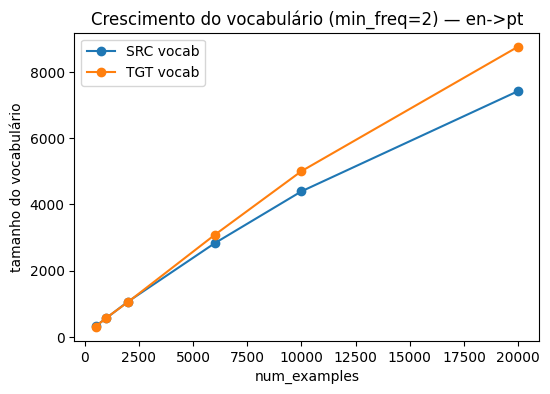

Salvo: /content/vocab_vs_examples.csv


In [13]:
plt.figure(figsize=(6,4))
plt.plot(df_vocab["num_examples"], df_vocab["vocab_src"], marker="o", label="SRC vocab")
plt.plot(df_vocab["num_examples"], df_vocab["vocab_tgt"], marker="o", label="TGT vocab")
plt.xlabel("num_examples"); plt.ylabel("tamanho do vocabulário")
plt.title(f"Crescimento do vocabulário (min_freq={MIN_FREQ}) — {SRC2}->{TGT2}")
plt.legend(); plt.show()

df_vocab.to_csv("/content/vocab_vs_examples.csv", index=False)
print("Salvo: /content/vocab_vs_examples.csv")
